out.grad 0.04289321881345247
out.data 5.828427124746192
self grad 0
output 0.25


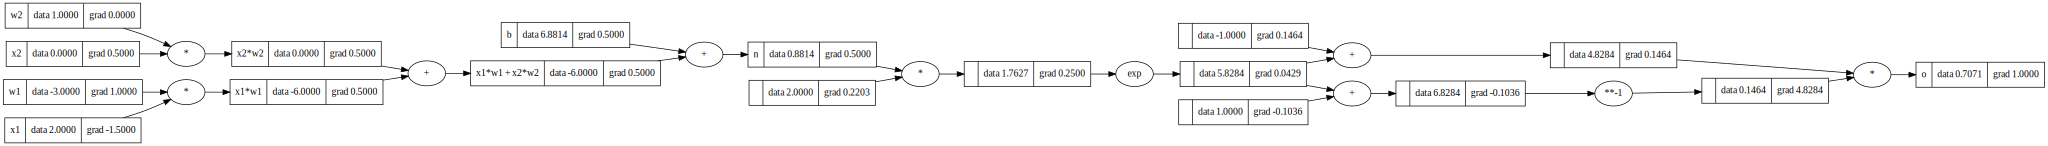

In [4]:
from graphviz import Source, Digraph
import math


class Value:
    def __init__(self, data, _children=(), op="", label=""):

        # if list then multiple pointers to same child may occur : not needed???

        self.data = data
        self._gradient = lambda: None
        self._prev = set(_children)
        self.grad = 0
        self._op = op
        self.label = label

    def __repr__(self) -> str:
        return f"Value({self.data})"

    def __add__(self, other):

        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data+other.data, (self, other), "+")

        def _gradient():
            self.grad += 1*out.grad
            other.grad += 1*out.grad

        out._gradient = _gradient
        # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        return out

    def __sub__(self, other):
        # if not isinstance(other, Value):
        #     other = Value(other)

        # out = Value(self.data-other.data, (self, other), "+")

        # def _gradient():
        #     self.grad += 1*out.grad
        #     other.grad += (-1*out.grad)

        # out._gradient = _gradient
        # # calling function to calculate gradient of output wrt self and other storing in grad attribute of self and other
        # return out
        return self+(-other)

    def __mul__(self, other):


        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data*other.data, (self, other), "*")

        def _gradient():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._gradient = _gradient
        return out

    def __rmul__(self, other):

        # a is self and 2 is other
        return self*other

    def backpropogate(self):
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
      build_topo(self)
        
      self.grad = 1.0
      for node in reversed(topo):
          node._gradient()

    def tanh(self):

        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), "tanh")

        def _gradient():
            self.grad += (1-t**2)*out.grad

        # we make it += because we can have multiple children and we want to add all the gradients(accummulate)

        out._gradient = _gradient
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _gradient():
            print("out.grad",out.grad)
            print("out.data",out.data)
            print("self grad",self.grad)
            print("output",out.data*out.grad)
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._gradient = _gradient
            
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")

        def _gradient():
            local_gradient = other*(self.data**(other-1))
            self.grad += local_gradient*out.grad

        out._gradient = _gradient
        return out

    def __truediv__(self, other):
        # a/b = a*(b**-1)
        return self*other**-1
    def __neg__(self): # -self
        return self * -1


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backpropogate()
draw_dot(o)

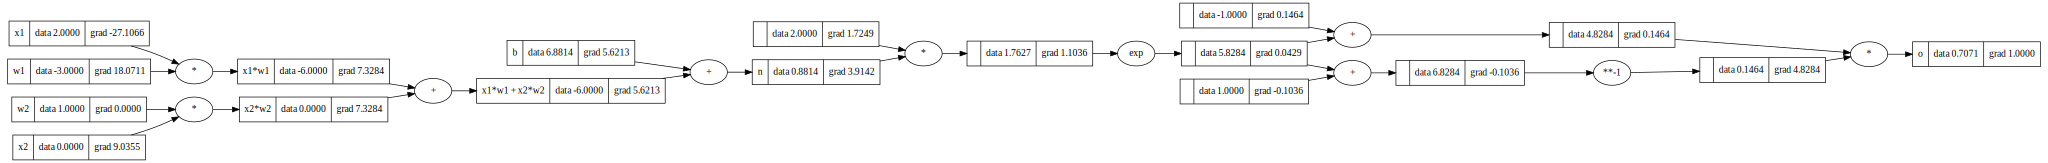

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(o)